In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def generate_real_data(n):
    radius = 1
    angles = np.linspace(0, 2 * np.pi, n)
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    data = np.vstack((x, y)).T
    return data

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 2),
            nn.Tanh()  # Output scaled to [-1, 1]
        )

    def forward(self, x):
        return self.main(x)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
# Hyperparameters
batch_size = 64
learning_rate = 0.0001
num_epochs = 5000
latent_size = 64

In [6]:
real_data = generate_real_data(1000)
real_data = torch.tensor(real_data, dtype=torch.float32)
dataloader = DataLoader(TensorDataset(real_data), batch_size=batch_size, shuffle=True)


In [7]:
generator = Generator()
discriminator = Discriminator()
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


In [8]:
for epoch in range(num_epochs):
    for real_batch, in dataloader:
        # Train Discriminator
        real_labels = 0.9 + 0.1 * torch.rand((real_batch.size(0), 1))  # Label smoothing + noise
        outputs = discriminator(real_batch)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(real_batch.size(0), latent_size)
        fake_data = generator(z)
        fake_labels = 0.1 * torch.rand((real_batch.size(0), 1))  # Some noise in fake labels

        outputs = discriminator(fake_data.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        for _ in range(2):  # Train G twice for better learning
            z = torch.randn(real_batch.size(0), latent_size)
            fake_data = generator(z)
            outputs = discriminator(fake_data)
            g_loss = criterion(outputs, torch.ones((real_batch.size(0), 1)))  # Fool discriminator
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

    # Logging
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], D_Loss: {d_loss.item():.4f}, G_Loss: {g_loss.item():.4f}')

    # Generate fake data for visualization
    if (epoch + 1) % 1000 == 0:
        with torch.no_grad():
            fake_data = generator(torch.randn(1000, latent_size)).cpu().numpy()

Epoch [500/5000], D_Loss: 1.6321, G_Loss: 0.4690
Epoch [1000/5000], D_Loss: 1.4623, G_Loss: 0.6591
Epoch [1500/5000], D_Loss: 1.5340, G_Loss: 0.6474
Epoch [2000/5000], D_Loss: 1.3711, G_Loss: 0.6682
Epoch [2500/5000], D_Loss: 1.4341, G_Loss: 0.6836
Epoch [3000/5000], D_Loss: 1.0270, G_Loss: 0.8686
Epoch [3500/5000], D_Loss: 1.2574, G_Loss: 0.8167
Epoch [4000/5000], D_Loss: 1.3688, G_Loss: 0.6975
Epoch [4500/5000], D_Loss: 1.3834, G_Loss: 0.7023
Epoch [5000/5000], D_Loss: 1.3871, G_Loss: 0.6920


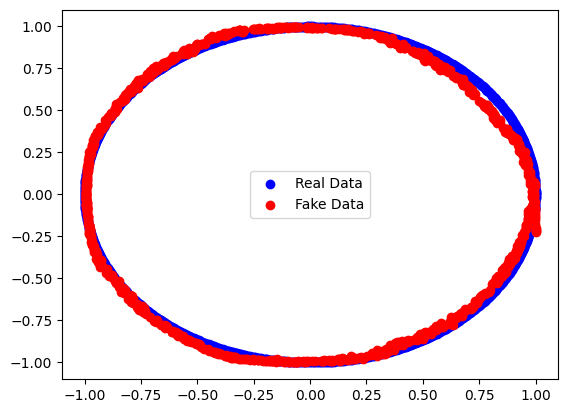

In [9]:
plt.scatter(real_data[:, 0], real_data[:, 1], color="blue", label="Real Data")
plt.scatter(fake_data[:, 0], fake_data[:, 1], color="red", label="Fake Data")
plt.legend()
plt.show()